# Analysis

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()
MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
J_DAYS = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
CITIES = ['מודיעין מכבים רעות', 'באר שבע', 'נתניה']
MODIIN,BS,NETANIA = CITIES

In [2]:
#full_df = pd.read_pickle('full.pkl')
full_hour_df = pd.read_pickle('hour.pkl')
full_day_df = pd.read_pickle('day.pkl')
id_df = pd.read_pickle('id.pkl')

In [3]:
full_hour_df.head(1)

,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,hour,consumption,ts,temperature,r_humidity,heat_index
0,199.341003,702552276,11,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,0,5.037,2022-01-01,10.7,81.0,10.7


In [5]:
full_day_df['log10_daily_consumption'] = np.log10(full_day_df.total + 1)
bad_buildings = set(full_day_df[(full_day_df.log10_daily_consumption > 4.5) | (full_day_df.count_reg > 30)].id.unique())
full_day_df['overconsuming'] = full_day_df.id.map(lambda x: x in bad_buildings)
day_df = pd.DataFrame(full_day_df[(full_day_df.overconsuming == False) & (full_day_df.year == 2022)])
hour_df = pd.DataFrame(full_hour_df[(full_hour_df.id.map(lambda x: x not in bad_buildings)) & (full_hour_df.year == 2022)])

full_day_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,date_y,total,temperature,r_humidity,heat_index,ts,log10_daily_consumption,overconsuming
0,702552276,11,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,2022-01-01,199.341003,10.7,81.0,10.7,2022-01-01,2.30177,False


In [6]:
id_df.head(1)

,count_reg,no.,city,city_code_HHI,city_code_LAMAS,street,address,lat,lng
id,,,,,,,,,
702552276,11,32,מודיעין מכבים רעות,1932,1200,חרצית,חרצית 32 מודיעין מכבים רעות,31.905869,35.010933


# Basic viz

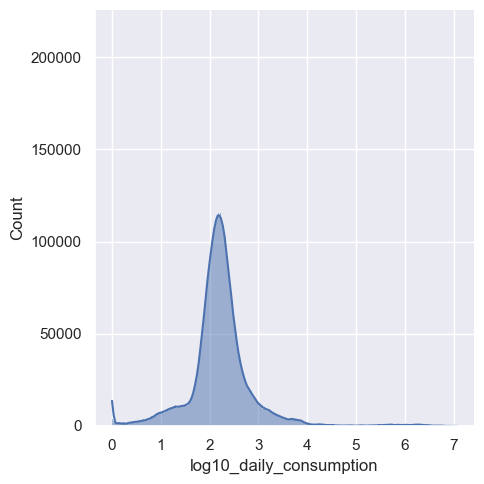

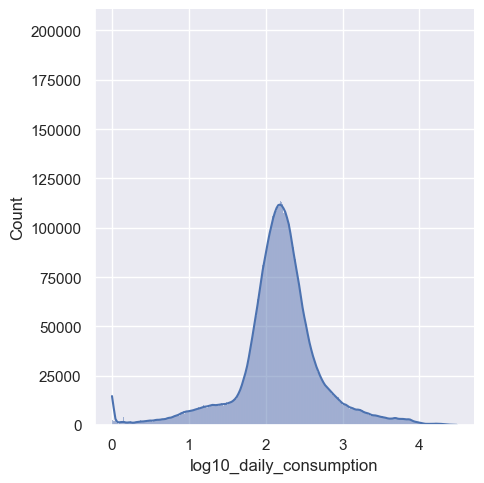

In [6]:
sns.displot(full_day_df.log10_daily_consumption, kde=True)
sns.displot(data=full_day_df[full_day_df.overconsuming == False], x='log10_daily_consumption', kde=True)

<Axes: xlabel='month', ylabel='total'>

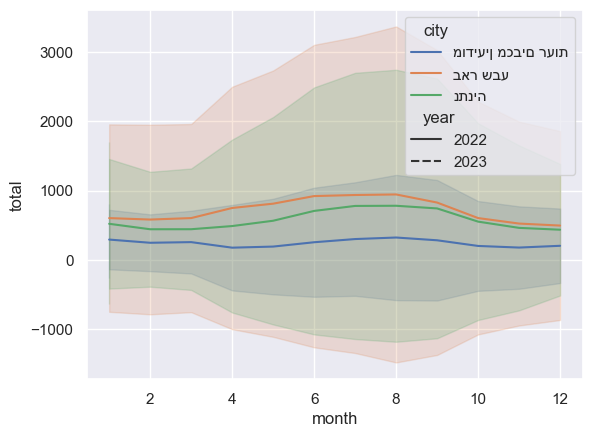

In [10]:
sns.lineplot(data=full_day_df[full_day_df.overconsuming == False], x='month', y='total', hue='city', style='year', errorbar='sd')
#day_df

In [12]:
def radar_plt(stats, ax, title, labels=None):
    if labels is None:
        labels = np.arange(1, len(stats)+1)
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)[::-1] # Set the angle
    stats=np.concatenate((stats,[stats[0]]))  # Closed
    angles=np.concatenate((angles,[angles[0]]))  # Closed
    ax.plot(angles, stats, 'o-', linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax.fill(angles, stats, alpha=0.25)  #Fulfill the area
    ax.set_thetagrids(angles * 180/np.pi, np.concatenate((labels, labels[:1])))  # Set the label for each axis
    ax.set_title(title)  # Set the pokemon's name as the title
    #ax.set_rlim(0,250)
    ax.grid(True)

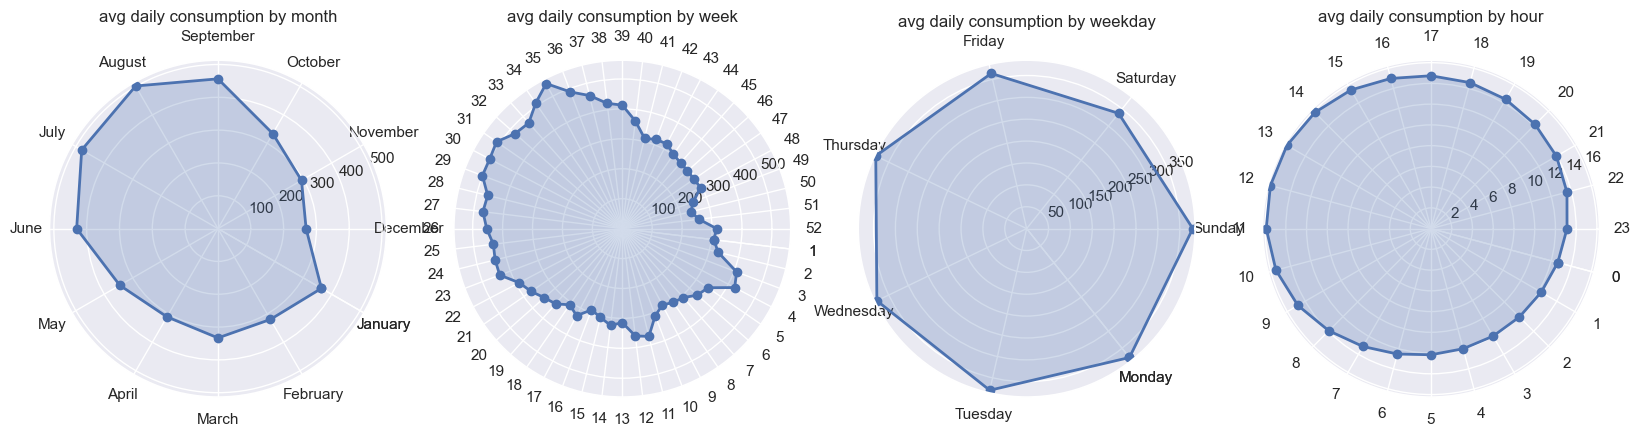

In [13]:
fig, axs = plt.subplots(figsize=(20, 5), nrows=1, ncols=4,
                            subplot_kw=dict(projection='polar'))
stats=day_df.groupby('month').mean(numeric_only=True).total.values
radar_plt(stats, axs[0], 'avg daily consumption by month', MONTHS)
stats=day_df.groupby('week').mean(numeric_only=True).total.values
radar_plt(stats, axs[1], 'avg daily consumption by week')
stats=day_df.groupby('weekday').mean(numeric_only=True).total.values
radar_plt(stats, axs[2], 'avg daily consumption by weekday', DAYS)
stats=hour_df.groupby('hour').mean(numeric_only=True).consumption.values
radar_plt(stats, axs[3], 'avg daily consumption by hour', np.arange(0,24))

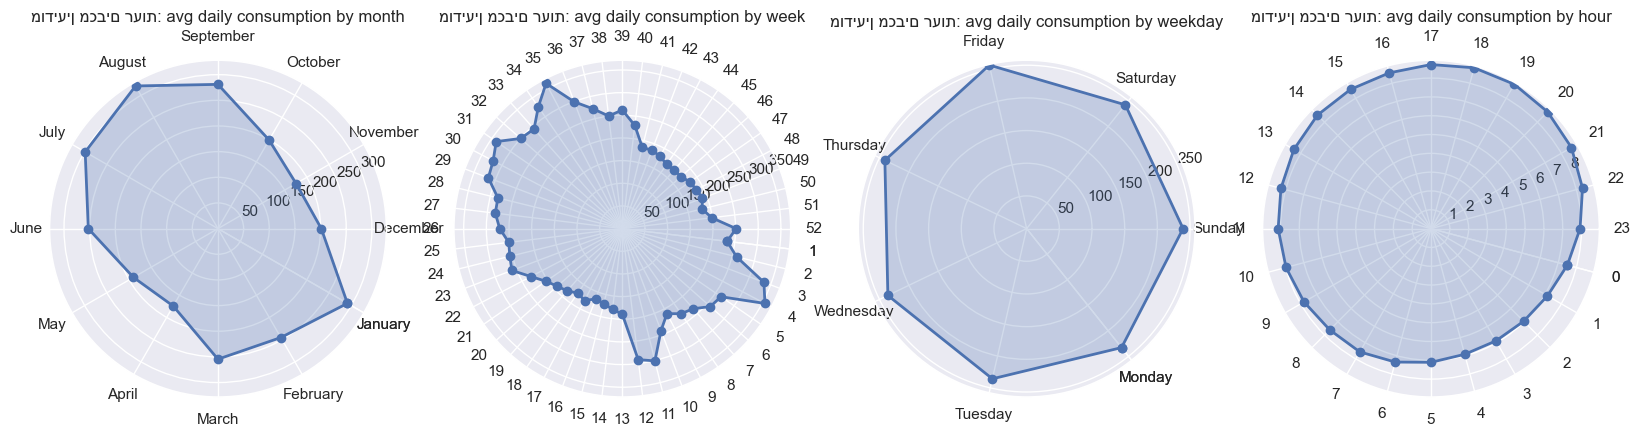

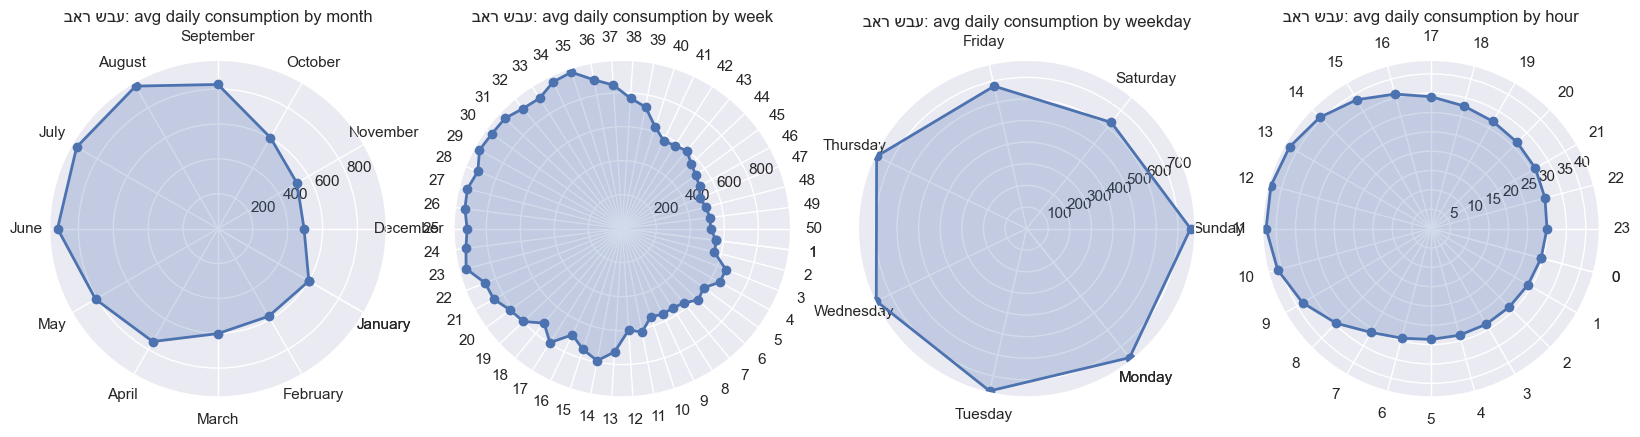

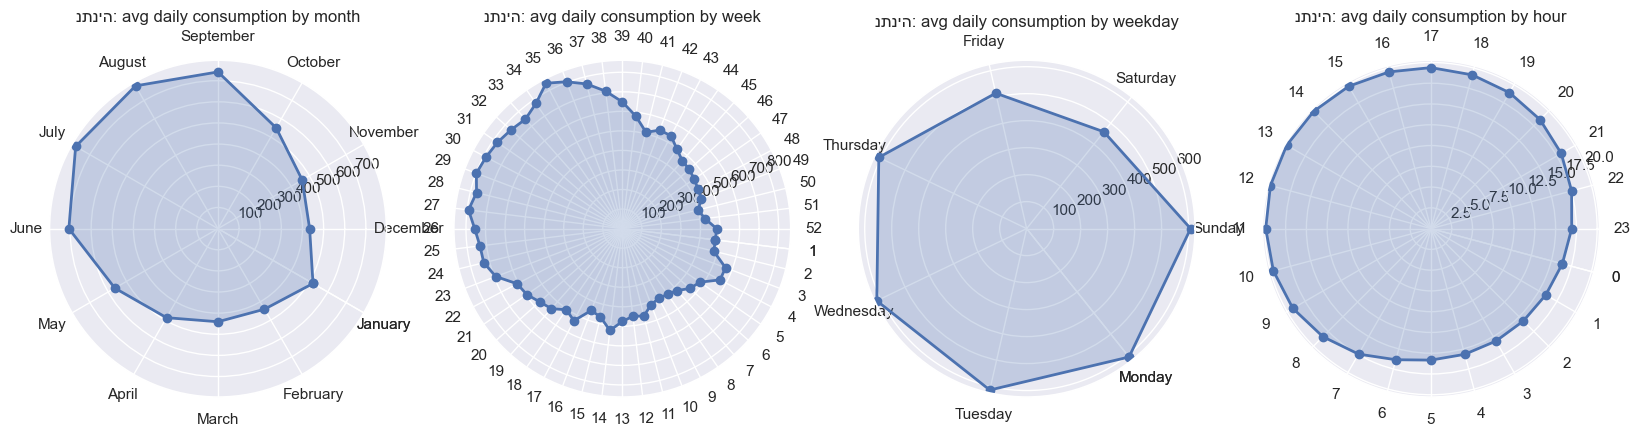

In [14]:
for city in CITIES:
    fig, axs = plt.subplots(figsize=(20, 5), nrows=1, ncols=4,
                                subplot_kw=dict(projection='polar'))
    stats=day_df[day_df.city == city].groupby('month').mean(numeric_only=True).total.values
    radar_plt(stats, axs[0], f'{city}: avg daily consumption by month', MONTHS)
    stats=day_df[day_df.city == city].groupby('week').mean(numeric_only=True).total.values
    radar_plt(stats, axs[1], f'{city}: avg daily consumption by week')
    stats=day_df[day_df.city == city].groupby('weekday').mean(numeric_only=True).total.values
    radar_plt(stats, axs[2], f'{city}: avg daily consumption by weekday', DAYS)
    stats=hour_df[hour_df.city == city].groupby('hour').mean(numeric_only=True).consumption.values
    radar_plt(stats, axs[3], f'{city}: avg daily consumption by hour', np.arange(0,24))

[Text(0.5, 1.0, 'consumption')]

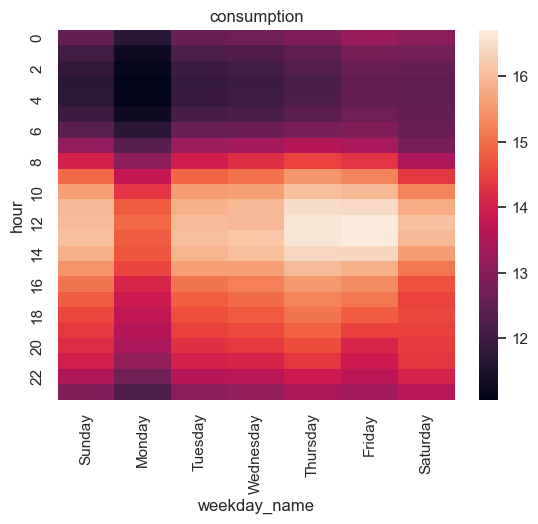

In [15]:
table = hour_df.groupby(['weekday_name', 'hour']).mean(numeric_only=True)['consumption'].reset_index().pivot(columns='weekday_name', index='hour', values='consumption')
sns.heatmap(table).set(title='consumption')

[Text(0.5, 1.0, 'MODIIN consumption')]

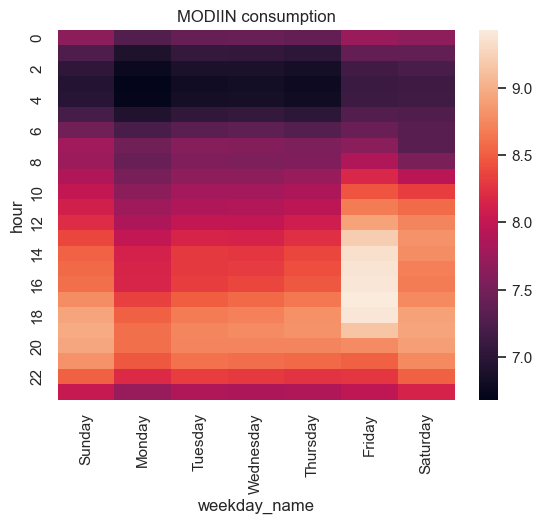

In [18]:
table = hour_df[hour_df.city == MODIIN].groupby(['weekday_name', 'hour']).mean(numeric_only=True)['consumption'].reset_index().pivot(columns='weekday_name', index='hour', values='consumption')
sns.heatmap(table).set(title='MODIIN consumption')

[Text(0.5, 1.0, 'consumption')]

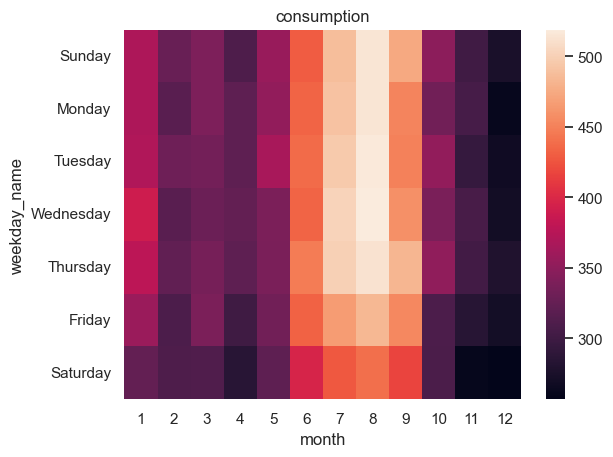

In [19]:
table = day_df.groupby(['weekday_name', 'month']).mean(numeric_only=True)['total'].reset_index().pivot(columns='month', index='weekday_name', values='total')
sns.heatmap(table).set(title='consumption')

<Axes: xlabel='weekday_name', ylabel='total'>

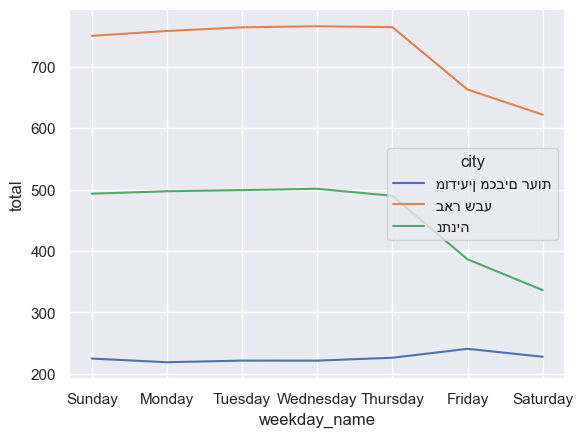

In [8]:
sns.lineplot(data=day_df, x='weekday_name', y='total', hue='city', errorbar=None)

<Axes: xlabel='rounded_heat_index', ylabel='total'>

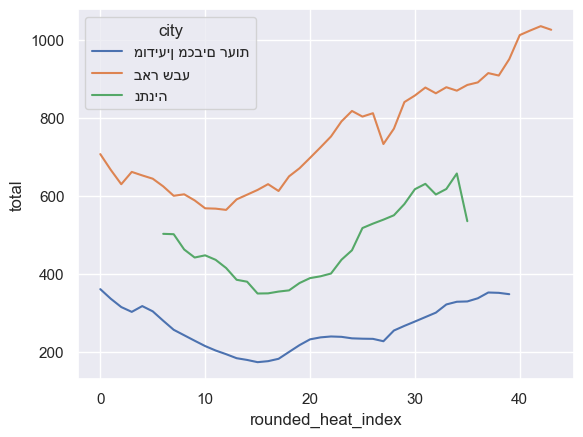

In [10]:
day_df['rounded_heat_index'] = day_df.heat_index.round(0)
sns.lineplot(data=day_df, x='rounded_heat_index', y='total', hue='city', errorbar=None)

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_21120\1272273005.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gr_df = day_df.groupby(['id', 'city']).mean()


<Axes: xlabel='count_reg', ylabel='total'>

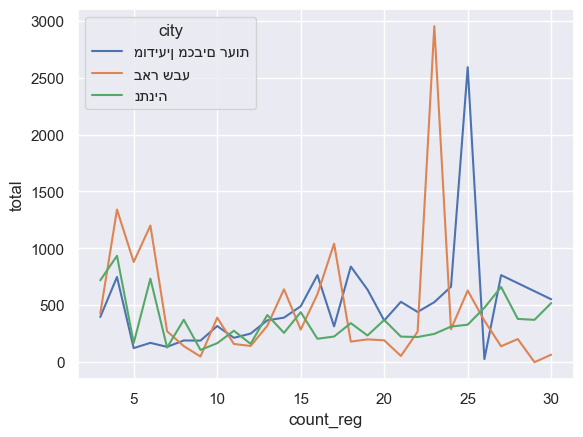

In [11]:
gr_df = day_df.groupby(['id', 'city']).mean()
sns.lineplot(data=gr_df, x='count_reg', y='total', hue='city', errorbar=None)

<Axes: xlabel='count_reg', ylabel='total'>

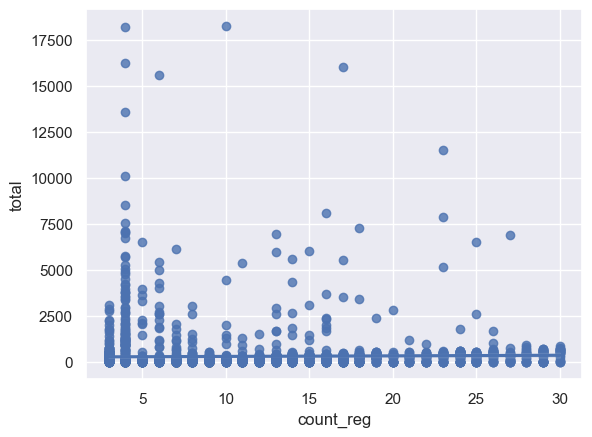

In [12]:
sns.regplot(data=gr_df, x='count_reg', y='total')

In [ ]:
sns.regplot(data=gr_df[(gr_df.count_reg < 50) & (gr_df.total < 2500)], x='count_reg', y='total')

In [ ]:
sns.displot(id_df[id_df.count_reg < 30].count_reg, kde=True)

# Outliers?

In [13]:
del full_day_df
del full_hour_df

In [14]:
w_df = pd.read_pickle('weather.pkl').reset_index(drop=True)
w_df = w_df[w_df.ts.dt.year == 2022]
w_df.tail(1)

,date,temperature,r_humidity,heat_index,city,ts
157519,2022-12-31 23:50:00,11.2,72,11.2,מודיעין מכבים רעות,2022-12-31 23:50:00


In [15]:
HOURS = [10,18]
tmp_df = w_df[(w_df.ts.dt.hour >= HOURS[0]) &(w_df.ts.dt.hour <= HOURS[1])].groupby([w_df.ts.dt.floor('D'), w_df.city]).mean(numeric_only=True).reset_index()
dfs = []
for city in CITIES:
    current = pd.DataFrame(tmp_df[tmp_df.city == city])
    temps = current['heat_index'].values
    for ws in [3,5,7, 10]:
        mean_temps = [temps[0]] + [temps[max(0, i-ws):i].mean() for i in range(1, len(temps))]
        current[f'past_{ws}'] = mean_temps

        mean_temps = [temps[max(0, i-ws):i+ws+1].mean() for i in range(len(temps))]
        current[f'around_{ws}'] = mean_temps
    dfs.append(current)
tmp_df = pd.concat(dfs)
tmp_df.head(5)

,ts,city,temperature,r_humidity,heat_index,past_3,around_3,past_5,around_5,past_7,around_7,past_10,around_10
1,2022-01-01,מודיעין מכבים רעות,9.805556,86.203704,9.805556,9.805556,10.725000,9.805556,11.502778,9.805556,12.752778,9.805556,12.626599
4,2022-01-02,מודיעין מכבים רעות,11.788889,79.407407,11.788889,9.805556,10.797037,9.805556,12.082804,9.805556,12.787449,9.805556,12.734877
7,2022-01-03,מודיעין מכבים רעות,10.903704,83.537037,10.903704,10.797222,11.502778,10.797222,12.752778,10.797222,12.585741,10.797222,12.655556
10,2022-01-04,מודיעין מכבים רעות,10.401852,92.907407,10.401852,10.832716,12.082804,10.832716,12.787449,10.832716,12.626599,10.832716,12.262566
13,2022-01-05,מודיעין מכבים רעות,11.085185,85.870370,11.085185,11.031481,13.173810,10.725000,12.585741,10.725000,12.734877,10.725000,11.820123


In [17]:
THRESHOLD = 4
tmp_df['doy'] = tmp_df.ts.dt.day_of_year
tmp_df['outlier'] = (tmp_df.heat_index - tmp_df.around_10) > THRESHOLD
tmp_df[tmp_df.outlier & (tmp_df.heat_index > 25) & (tmp_df.city == MODIIN)]

,ts,city,temperature,r_humidity,heat_index,past_3,around_3,past_5,around_5,past_7,around_7,past_10,around_10,doy,outlier
271,2022-04-01,מודיעין מכבים רעות,26.431481,24.481481,25.914659,19.082099,22.040390,16.905556,20.826269,14.692857,19.086301,12.467778,17.327517,91,True
283,2022-04-05,מודיעין מכבים רעות,27.261111,20.277778,26.370609,23.707257,22.504265,23.587286,22.095798,22.040390,20.604820,19.317162,19.112702,95,True
319,2022-04-17,מודיעין מכבים רעות,27.833333,11.703704,26.388532,19.590123,20.371288,17.397778,19.382399,17.751058,19.532031,18.162778,20.121404,107,True
355,2022-04-29,מודיעין מכבים רעות,27.955556,34.685185,27.224028,23.027527,22.735349,23.056026,22.426363,22.845570,21.479208,21.110417,20.810477,119,True
400,2022-05-14,מודיעין מכבים רעות,31.929630,21.388889,30.136452,22.704724,23.028131,23.074400,23.360580,21.919545,23.202659,20.064793,21.883469,134,True
484,2022-06-11,מודיעין מכבים רעות,32.085185,24.518519,30.491605,27.734530,26.531234,26.963585,26.394626,26.986009,26.593874,26.331413,26.047454,162,True
718,2022-08-28,מודיעין מכבים רעות,31.940741,56.203704,35.257942,30.619071,32.790699,29.644568,31.521026,29.111964,30.697326,28.749083,29.694257,240,True
721,2022-08-29,מודיעין מכבים רעות,31.246296,59.814815,34.611076,32.108963,32.762612,31.321402,31.773031,30.066977,30.647895,29.466304,29.728552,241,True
724,2022-08-30,מודיעין מכבים רעות,31.244444,59.555556,34.904614,33.651817,32.799268,32.345246,31.684851,31.155980,30.559061,30.182835,29.785237,242,True
817,2022-09-30,מודיעין מכבים רעות,29.272222,48.314815,30.001426,26.464597,27.274420,27.060188,27.102770,26.986242,26.499934,25.868332,25.317854,273,True


In [18]:
doys = [[83,100],[103, 112], [115, 124], [130,138],[157,167],[235,247],[268,278]]

In [19]:
city_day_df = day_df[['city', 'ts', 'total', 'day_of_year']].groupby(['city', 'ts']).mean(numeric_only=False).reset_index() 
city_day_df['friday'] = city_day_df.ts.dt.weekday == 4
city_day_df.head(1)

,city,ts,total,day_of_year,friday
0,באר שבע,2022-01-01,429.153839,1.0,False


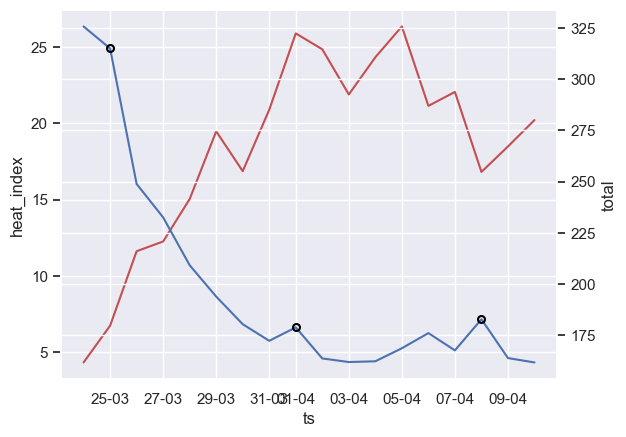

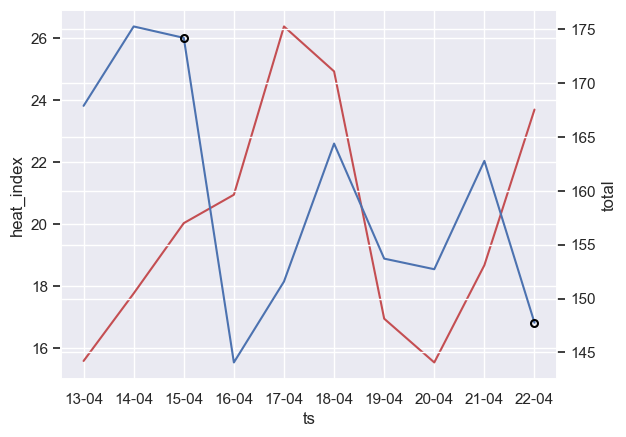

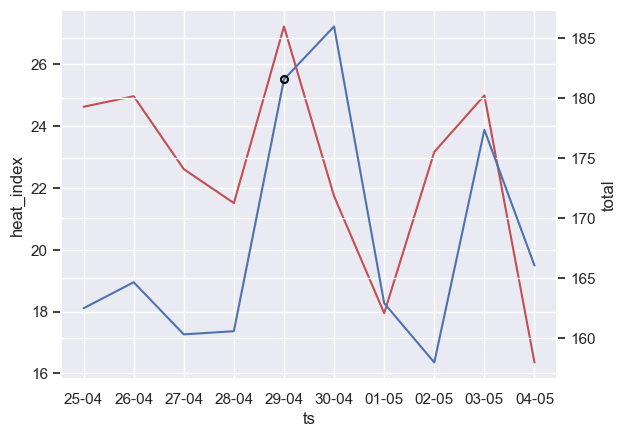

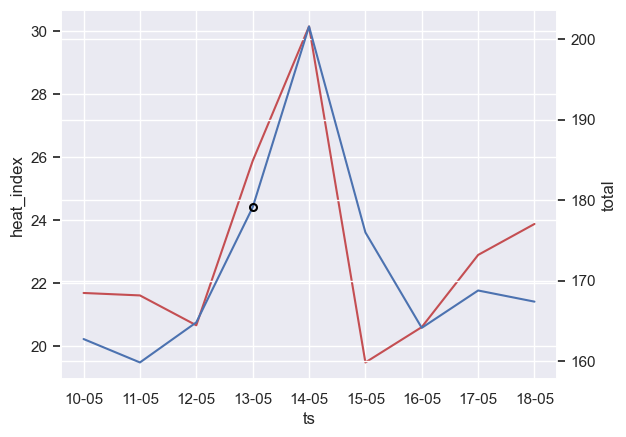

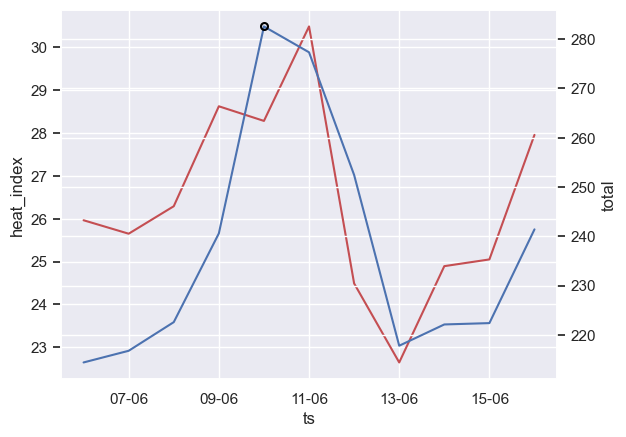

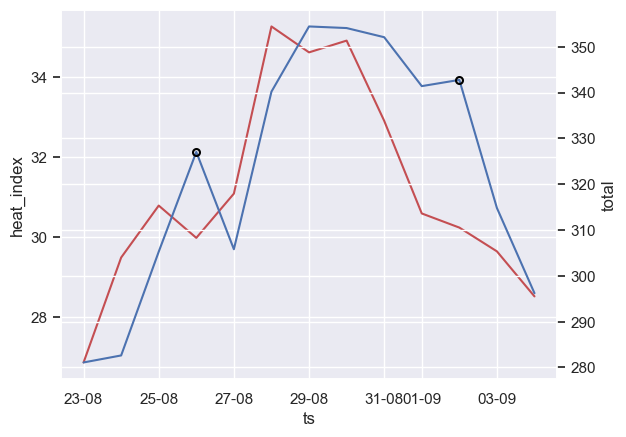

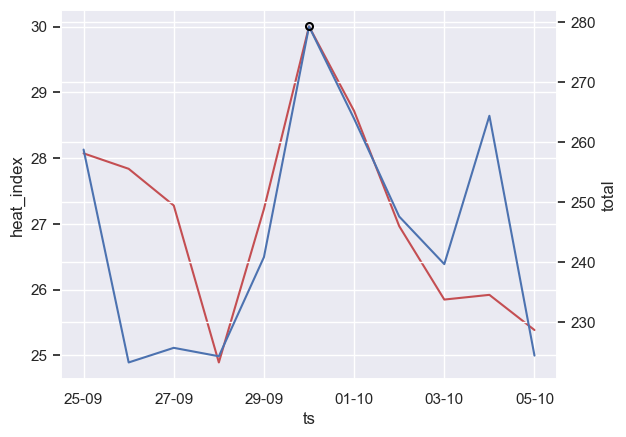

In [20]:
from matplotlib import pyplot as plt, dates as mdates
for doy in doys:
    plt.figure()
    ax = sns.lineplot(x='ts', y='heat_index', data=tmp_df[(tmp_df.doy >= doy[0])&(tmp_df.doy <= doy[1]) & (tmp_df.city == MODIIN)], color="r")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax2 = plt.twinx()
    tmp = city_day_df[(city_day_df.day_of_year >= doy[0])&(city_day_df.day_of_year <= doy[1]) & (city_day_df.city == MODIIN)]
    places = list(np.where(tmp.friday)[0])
    sns.lineplot(x='ts', y='total', data=tmp, color="b",
                marker = 'o', markersize=5, fillstyle='none', markeredgewidth=1.5, markeredgecolor='black', markevery=places)

#ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))